## Supervisor MultiAgent

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="deepseek-r1-distill-llama-70b")
print(llm.invoke("What is the capital of France?").content)


<think>

</think>

The capital of France is Paris.


### Tavily Search Tool

In [3]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

C:\Users\Harshit\AppData\Local\Temp\ipykernel_23228\156554669.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)


In [4]:
search_tool.invoke("What is the capital of France?")

[{'title': 'List of capitals of France - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/List_of_capitals_of_France',
  'content': 'This is a chronological list of capitals of France. The capital of France has been Paris since its liberation in 1944.\n\n## Chronology\n\n[edit] [...] - Tours (10–13 June 1940), the city served as the temporary capital of France during World War II after the government fled Paris due to the German advance.\n- Bordeaux (June 1940), the government was relocated from Paris to Tours then Bordeaux very briefly during World War II, when it became apparent that Paris would soon fall into German hands. [...] - Paris (1789–1871), on 5 and 6 October 1789, a throng from Paris invaded the castle and forced the royal family to move back to Paris. The National Constituent Assembly "National Constituent Assembly (France)") followed the King to Paris soon afterward; Versailles lost its role of capital city.',
  'score': 0.8993429},
 {'title': 'What are the three offi

### PythonREPL

In [5]:
my_code = """
x=10
y=x+10
print(y)
"""

In [6]:
from langchain_experimental.utilities import PythonREPL
repl=PythonREPL()


In [7]:
repl.run(my_code)

Python REPL can execute arbitrary code. Use with caution.


'20\n'

In [8]:
from typing import Annotated
from langchain_core.tools import tool

@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Harshit\AppData\Local\Temp\ipykernel_23228\3172908062.py:14: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\Harshit\AppData\Local\Temp\ipykernel_23228\3172908062.py:14: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [9]:
python_repl_tool.invoke("x=10\ny=x+10\nprint(y)")


'Successfully executed:\n\\`\\`\\`python\nx=10\ny=x+10\nprint(y)\n\\`\\`\\`\nStdout: 20\n'

In [10]:
python_repl_tool.invoke(my_code)


'Successfully executed:\n\\`\\`\\`python\n\nx=10\ny=x+10\nprint(y)\n\n\\`\\`\\`\nStdout: 20\n'

#### WE HAVE TWO SUB AGENT

- RESEARCHER- internet
- CODER- executing the code

In [11]:
members=["researcher","coder"]

members

['researcher', 'coder']

In [12]:
options = members+["FINISH"]
options

['researcher', 'coder', 'FINISH']

#### There is no routing logic
- it is simply going to return the next candidate(next_agent)
- this next is containig the next candidate name

In [13]:
from typing import Literal
from typing_extensions import TypedDict

In [14]:
class Router(TypedDict):
    next: Literal['researcher', 'coder', 'FINISH']

### Workflow

In [15]:
from langgraph.graph import MessagesState, StateGraph, START, END

In [17]:
class State(MessagesState):
    next: str

# State will look like this

# state={"messages": ["hi"], "next": "research_agent"}

In [18]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

#### Agents

In [19]:
from langgraph.types import Command

In [ ]:
def supervisor_agent(state: State)->Command[Literal['researcher', 'coder', '__end__']]:
    messages = [{"role": "system", "content": system_prompt}, ] + state["messages"]

    llm_with_structured_output = llm.with_structured_output(Router)

    response = llm_with_structured_output.invoke(messages)

    # this is my next worker agent
    goto = response["next"]

    print("***************BELOW IS MY GOTO****************")

    print(goto)

    if goto == "FINISH":
        return '__end__'
    
    return Command(goto= goto, update={"next": goto})

In [38]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage

In [39]:
def researcher_agent(state: State)->Command[Literal['supervisor']]:
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")

    result = research_agent.invoke(state)

    return Command(
        update = {
            "messages": [
                HumanMessage(content = result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor"
    )

In [40]:
def coder_agent(state: State)->Command[Literal['supervisor']]:
    code_agent = create_react_agent(llm, tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")

    result = code_agent.invoke(state)

    return Command(
        update = {
            "messages": [
                HumanMessage(content = result["messages"][-1].content, name = "coder")
            ]
        },
        goto="supervisor"
    )

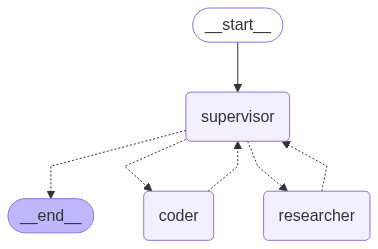

In [41]:
graph = StateGraph(State)

graph.add_node("supervisor", supervisor_agent)
graph.add_node("researcher", researcher_agent)
graph.add_node("coder", coder_agent)

graph.add_edge(START, "supervisor")

app = graph.compile()

app

In [47]:
for s in app.stream({"messages": [("user", "What's the square root of 49?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

***************BELOW IS MY GOTO****************
researcher
((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************
(('researcher:e148808b-b6da-1f88-d9bc-3756be436eed',), {'agent': {'messages': [AIMessage(content='The square root of 49 is 7. \n\nStep-by-step explanation:\n1. Understand that the square root of a number is a value that, when multiplied by itself, gives the original number.\n2. Recognize that both positive and negative numbers squared give a positive result.\n3. Identify that 7 multiplied by 7 equals 49.\n4. Conclude that the principal square root of 49 is 7.\n\nAnswer: 7', additional_kwargs={'reasoning_content': "Okay, so I need to figure out the square root of 49. Hmm, I remember that the square root of a number is a value that, when multiplied by itself, gives the original number. So, in this case, I'm looking for a number which, when squared, equals 49.\n\nLet me think, I know that 7 times 7 is 49 because 7 squared is 49. Wait, but isn't

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '\n\nTo find the square root of 49, follow these steps:\n\n1. **Understand the concept of square roots**: The square root of a number is a value that, when multiplied by itself, gives the original number.\n\n2. **Identify the number**: In this case, the number is 49.\n\n3. **Find the square root**:\n   - Recognize that both positive and negative numbers can be square roots since a negative number multiplied by itself also yields a positive result.\n   - Consider the equation \\( x \\times x = 49 \\).\n\n4. **Calculate the square root**:\n   - Test the number 7: \\( 7 \\times 7 = 49 \\).\n   - Since this equation holds true, 7 is a square root of 49.\n\n5. **Determine the principal square root**: The principal square root is the non-negative value, which in this case is 7.\n\n6. **Conclusion**: The square root of 49 is 7.\n\nAnswer: 7'}}

In [48]:
result=app.invoke({"messages": [("user", "what is an efficent python code to get prime number?")]}, subgraphs=True)


***************BELOW IS MY GOTO****************
researcher
***************BELOW IS MY GOTO****************
coder
***************BELOW IS MY GOTO****************
researcher
***************BELOW IS MY GOTO****************
researcher
***************BELOW IS MY GOTO****************
coder


KeyboardInterrupt: 